<a href="https://colab.research.google.com/github/jfgf11/Examen-2-Machine/blob/master/examen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Examen 2




En este informe se presenta la solucion al Examen Parcial 2 de Machine Learning.
En este se debía atacar el problema de clasificación de estados de sueño y entrenar un modelo capaz de predecir si una persona se encuentra Despierta (0), en Sueño Ligero (1), en Sueño Profundo (2) o en Sueño REM (3). Para esto, se utilizó la base de datos de Sleep Cassette Study and Data. Dicha base de datos contaba con 6 señales para diferentes sujetos durante 2 días. Además, esta contaba con una valoración realizada por expertos del estado de sueño en el que cada sujeto se encontraba en ventanas de 30 segundos. Así, el problema se resume en obtener estas señales junto con las etiquetas correctas y construir un clasificador que, a partir de una toma de 30 segundos de las señales de una persona, sea capaz de predecir el estado de sueño en el que se encuentra.

In [1]:
#Se monta el Drive para importar y guardar los datos y modelos.
from google.colab import drive
drive.mount('/content/drive')#,force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Instalación

In [2]:
#Se instalan las librerías que se necesitan.
!pip install pyEDFlib
!pip install progressbar2
!pip install matplotlib --upgrade
!pip install h5py

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=920126 sha256=5482792f9dfdc0241d40be8082b0499ba433d9e341fc377c13bdf339732408d8
  Stored in directory: /root/.cache/pip/wheels/57/e3/8e/ce6236e9ada08b8ff91ef922c7418dbd66f1182dfbb22f8579
Successfully built pyEDFlib
     |████████████████████████████████| 13.1MB 2.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1


#Librerías

In [1]:
#Se importan las librerías requeridas.
#Se deben primero instalar las librerías que hacen falta con la celda en la
#sección de Instalación.
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Model
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

import pandas as pd
import pyedflib as pyedf
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import seaborn as sns
import progressbar

#Se recomienda utilizar la version 3.1.2 de matplotlib.
#Si no se esta usando esta version, se debe reiniciar el runtime y volver a importar
#las librerías.
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

import itertools

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


#Clases

In [0]:
#Clase utilizada para presentar los resultados de los modelos.
#En esta se incluye: una grafica de la historia de entrenamiento y validación,
#calculo de las metricas de accuracy, precision, recall y f1 con promedio macro,
#construccion de reporte de las metricas, grafica de la matriz de confusion,
#y un grafica en el tiempo de los estados de sueño.
class Resultados:
    def __init__(self, p_y_pred, p_y_true, pHist, pModelo, pId):
        self.y_pred = p_y_pred
        self.y_true = p_y_true
        self.hist = pHist
        self.modelo = pModelo
        self.iden = pId

    def graficarMatrizConfusion(self):
      cm = confusion_matrix(self.y_true, self.y_pred)
      
      plt.figure(figsize=(8,8))

      ax = sns.heatmap(cm, annot = True, cbar = False);
      
      ax.xaxis.tick_top()
      ax.xaxis.set_label_position('top')
      
      plt.xlabel("Clase Prediccion")
      plt.ylabel("Clase Verdadera")
      plt.title("Matriz de Confusion")

      plt.show()
      plt.savefig("drive/My Drive/DatosExamen2/results/MatrizConfusion_" + self.iden + ".png")

    def graficarHistoria(self):
      plt.plot(self.hist.history['sparse_categorical_accuracy'], label = 'Accuracy Entrenamiento')
      plt.plot(self.hist.history['val_sparse_categorical_accuracy'], label = 'Accuracy Validacion')
      plt.xlabel('Epoca')
      plt.ylabel('Accuracy')
      plt.title("Accuracy vs Epoca")
      plt.legend()
      plt.show()

    def calcularError(self):
      error = np.sum(self.y_pred != self.y_true)
      error = error/len(self.y_pred)

      return error

    def calcularF1(self):
      f1 = f1_score(self.y_true, self.y_pred, average = 'micro')
      return f1

    def calcularPrecision(self):
      precision = precision_score(self.y_true, self.y_pred, average = 'micro')
      return precision

    def calcularRecall(self):
      recall = recall_score(self.y_true, self.y_pred, average = 'micro')
      return recall

    def darReporte(self):
      print(classification_report(self.y_true, self.y_pred, labels = np.arange(0, max(self.y_true)+1)))

    def graficarPrediccionNoche(self, pX, p_y_true):
      x1 = pX[0]
      x2 = pX[1]
      
      x1 = x1[np.array([p_y_true != "Sleep stage ?"])[0,:,0], :, :]
      x2 = x2[np.array([p_y_true != "Sleep stage ?"])[0,:,0], :, :]

      y_true = p_y_true[p_y_true != "Sleep stage ?"]
      y_true = ((y_true == "Sleep stage 1") + (y_true == "Sleep stage 2")) + 2*((y_true == "Sleep stage 3") + (y_true == "Sleep stage 4")) + 3*(y_true == "Sleep stage R")

      y_prob = modelo.predict([x1, x2])
      y_pred = y_prob.argmax(axis = -1)
      y_pred = ((y_pred == 1) + (y_pred == 2)) + 2*((y_pred == 3) + (y_pred == 4)) + 3*(y_pred == 5)

      t = np.arange(0, len(y_true))*30
      
      plt.figure(figsize=(25,10))
      plt.plot(t, y_true, label = "Verdadero")
      plt.plot(t, y_pred, label = "Prediccion")

      plt.title("Grafica de Predicciones y Verdaderas")
      plt.xlabel("Tiempo (Segundos)")
      plt.ylabel("Estado de Sueño")
      plt.legend()

      plt.show()
      plt.savefig('drive/My Drive/DatosExamen2/results/GraficaNoche_' + self.iden + '.png', bbox_inches='tight')

#Lectura de los Datos

El primer paso era aquel de obtener las 6 señales correspondientes a cada paciente en ventanas de 30 segundos y almacenarlos junto con su correspondiente etiqueta. Cada una de estas señales fue muestreada a una frecuencia específica, motivo por el cual se tenían más datos de aquellas muestreadas a frecuencias más altas. Más adelante se explicará que el tipo de arquitectura de la red neuronal escogida permite utilizar datos con diferentes frecuencias de muestreo. No obstante, era importante conocer la frecuencia de muestreo de cada señal para lograr construir la ventana de 30 segundos correctamente. Estas 6 señales se indican a continuación junto con la frecuencia de muestreo.
1. EEG Fpz-Cz (100Hz)
2. EEG Pz-Oz (100Hz)
3. EOG horizontal (100Hz)
4. Respiración Oral-nasal (1Hz)
5. Temperatura Rectal (1Hz)
6. EMG submental (1Hz)

Así, en esta sección se realizó el proceso de leer cada una de las 6 señales para los 153 archivos y almacenarla en una matriz de NumPy. Dicha matriz de NumPy también se guardó por facilidad.

In [0]:
#Esta celda permite importar las matrices de NumPy almacenadas en la ruta indicada por la variable rutaDatos.
rutaDatos = "drive/My Drive/DatosExamen2/processed"

#Se recomienda correr la siguiente celda y no esta para obtener los datos agrupados.

#Esta funcion junta cada uno de los 15 archivos .npy de DatosCompletos en una sola matriz de NumPy
#para su posterior preparacion.
def importarDatos():
  datos = np.zeros((1,3000))
  datos2 = np.zeros((1,30, 3))
  etiquetas = np.zeros(1)

  p = 0

  with progressbar.ProgressBar(max_value = 15) as bar:
    for i in range(0,2):
        for j in range(0,10):
          if i == 1 and j == 5:
            datos = datos[1:len(datos)]
            datos2 = datos2[1:len(datos2)]
            etiquetas = etiquetas[1:len(etiquetas)]
            return datos, datos2, etiquetas

          numInferior = str(i) + str(j) + "0"
          numSuperior = str(i) + str(j) + "9"

          temp1 = np.load(rutaDatos + "/DatosCompletos_" + numInferior  + "_" + numSuperior + ".npy")
          temp2 = np.load(rutaDatos + "/DatosCompletos2_" + numInferior  + "_" + numSuperior + ".npy")
          temp3 = np.load(rutaDatos + "/Etiquetas_" + numInferior  + "_" + numSuperior + ".npy")

          datos = np.vstack((datos, temp1))
          datos2 = np.vstack((datos2, temp2))
          etiquetas = np.append(etiquetas, temp3)
          
          p+=1
          bar.update(p)
        
  datos = datos[1:len(datos)]
  datos2 = datos2[1:len(datos2)]
  etiquetas = etiquetas[1:len(etiquetas)]
  
  return datos, etiquetas #datos2, etiquetas

unosDatos, unosDatos2, unosEtiquetas = importarDatos()

In [3]:
#En esta celda se cargan los datos totales correspondientes a 130 archivos de informacion.
#Se recomienda correr esta celda y no la anterior para obtener los datos agrupados.
start = time.time()

#En esta variable se almacenan los datos correspondientes a las primeras 3 señales muestreadas a una frecuencia de 100Hz.
unosDatos = np.load("drive/My Drive/DatosExamen2/processed/DatosTotalesCorregidos_020_149.npy")

#En esta variable se almacenan los datos correspondientes a las segundas 3 señales muestreadas a una frecuencia de 1Hz.
unosDatos2 = np.load("drive/My Drive/DatosExamen2/processed/DatosTotalesCorregidos2_020_149.npy")

#En esta variable se almacenan las etiquetas asociadas a cada ventana de 30 segundos.
unosEtiquetas = np.load("drive/My Drive/DatosExamen2/processed/EtiquetasTotalesCorregidas_020_149.npy")

print("Tiempo: {} segundos".format(time.time() - start))

Tiempo: 255.85004329681396 segundos
(124643, 30, 3)


In [0]:
#Esta celda permite leer los archivos de la base de datos.
#Para esto, se indica en la variable inicioNumArchivos con cual archivo comenzar y
#en numArchivos cuantos archivos leer.

filenameDatos = "drive/My Drive/sleep-cassette"
filenameDescripcion = "drive/My Drive/SC-subjects.xls"

ArchivoLightsOff=pd.read_excel(filenameDescripcion, sheet_name='Blad1')

TiempoLightsOff=ArchivoLightsOff["LightsOff"].values
TiempoLightsOffSegundos=TiempoLightsOff
HorasSuenio=8

for i in range (0, len(TiempoLightsOff)):
  segundos=int(TiempoLightsOff[i].hour) * 3600 + int(TiempoLightsOff[i].minute) * 60
  TiempoLightsOffSegundos[i]=segundos

listaArchivos = os.listdir(filenameDatos)

listaHypnograms = [i for i in listaArchivos if "Hypnogram" in i] 
listaPSGs = [i for i in listaArchivos if "PSG" in i]

listaHypnograms.sort()
listaPSGs.sort()

start = time.time()

Datos1=np.zeros(3000)
Datos2=np.zeros(3000)
Datos3=np.zeros(3000)

Etiquetas=[0]

p = 0
inicioNumArchivos = 20
numArchivos = 130

with progressbar.ProgressBar(max_value=numArchivos*960) as bar:
  for i in range(inicioNumArchivos,inicioNumArchivos+numArchivos):#len(listaHypnograms)):

    hyp = listaHypnograms[i]
    psg = listaPSGs[i]

    fileHyp = pyedf.EdfReader(filenameDatos + "/" + hyp)
    filePSG = pyedf.EdfReader(filenameDatos + "/" + psg)

    hypTime, hypDur, hypEtiqueta = fileHyp.readAnnotations()

    tiempoComienzo = fileHyp.starttime_hour*3600+fileHyp.starttime_minute*60+fileHyp.starttime_second
    offset=TiempoLightsOffSegundos[i]-tiempoComienzo
    if offset<0:
      offset+=24*3600
    LimiteSuperior=offset+HorasSuenio*3600
    ventana=30
    tiempo=offset
    j=0
    referenciaSenial=0
    FrecuenciaMuestreo = filePSG.getSampleFrequency(referenciaSenial)

    while tiempo<LimiteSuperior:
      if tiempo>=hypTime[j+1]:
        j+=1
        
      # ventanaMuestra = np.round(FrecuenciaMuestreo * ventana)
      # muestraInicial = np.round(FrecuenciaMuestreo * tiempo)
      # senial1=filePSG.readSignal(0)
      # senial2=filePSG.readSignal(1)
      # senial3=filePSG.readSignal(2)
      # senialActual1=senial1[muestraInicial:muestraInicial+ventanaMuestra]
      # senialActual2=senial2[muestraInicial:muestraInicial+ventanaMuestra]
      # senialActual3=senial3[muestraInicial:muestraInicial+ventanaMuestra]
      
      etiquetaActual=hypEtiqueta[j]
      
      # Datos1=np.vstack((Datos1,senialActual1))
      # Datos2=np.vstack((Datos2,senialActual2))
      # Datos3=np.vstack((Datos3,senialActual3))

      Etiquetas=np.vstack((Etiquetas,etiquetaActual))
      tiempo+=ventana
      p+=1
      bar.update(p)

    fileHyp._close() 
    filePSG._close()
#print(listaHypnograms)
#print(listaPSGs)

Etiquetas = Etiquetas[1:len(Etiquetas)]

N/A% (0 of 124800) |                     | Elapsed Time: 0:00:00 ETA:  --:--:--

Importando datos...


100% (124800 of 124800) |################| Elapsed Time: 0:05:08 Time:  0:05:08


Termino.
Tiempo: 309.40125346183777 segundos.


In [0]:
def appendDatos(pDatos1, pDatos2, pDatos3):
  Datos_Generales=np.zeros((pDatos1.shape[0],3000,3))

  for i in progressbar.progressbar(range(0,pDatos1.shape[0])):
    
    Datos_Generales[i,:,0]=pDatos1[i]
    Datos_Generales[i,:,1]=pDatos2[i]
    Datos_Generales[i,:,2]=pDatos3[i]
    
  return Datos_Generales

Datos1=np.zeros(3000)
Datos2=np.zeros(3000)
Datos3=np.zeros(3000)

for i in range(0, 2):
  for j in range(0, 10):
    if i == 0 and j > 1 or i == 1 and j < 5:
      intervalo = str(i) + str(j) + "0_" + str(i) + str(j) + "9"

      temp1 = np.load("drive/My Drive/DatosExamen2/raw/Datos1_" + intervalo + "_raw.npy")
      temp2 = np.load("drive/My Drive/DatosExamen2/raw/Datos2_" + intervalo + "_raw.npy")
      temp3 = np.load("drive/My Drive/DatosExamen2/raw/Datos3_" + intervalo + "_raw.npy")

      Datos1 = np.vstack((Datos1,temp1))
      Datos2 = np.vstack((Datos2,temp2))
      Datos3 = np.vstack((Datos3,temp3))

Datos1 = Datos1[1:len(Datos1)]
Datos2 = Datos2[1:len(Datos2)]
Datos3 = Datos3[1:len(Datos3)]

DatosCompletosRaw = appendDatos(Datos1, Datos2, Datos3)

print(DatosCompletosRaw.shape)

100% (124800 of 124800) |################| Elapsed Time: 0:00:02 Time:  0:00:02


(124800, 3000, 3)


In [0]:
np.save("drive/My Drive/DatosExamen2/raw/DatosCompletos_020_149_raw", DatosCompletosRaw)
np.save("drive/My Drive/DatosExamen2/raw/EtiquetasCompletas_020_149_raw", Etiquetas)

In [0]:
# np.save("drive/My Drive/DatosExamen2/processed/DatosTotalesCorregidos_020_149", unosDatos)
np.save("drive/My Drive/DatosExamen2/processed/EtiquetasTotalesCorregidas_020_149", unosEtiquetas)

In [0]:
#Reemplazar este por la nueva manera de hacerlo.
def eliminarClaseDesconocida(pDatos, pEtiquetas):
  et = []
  dat = np.zeros((3000,3))

  with progressbar.ProgressBar(max_value=numArchivos*960) as bar:
    for i in range(0, len(pEtiquetas)):
      bar.update(i)
      if pEtiquetas[i] != 'Sleep stage ?':
        
        if pEtiquetas[i]=="Sleep stage W":
          et = np.append(et,0)
          dat = np.vstack((dat, pDatos[i,:,:]))
        elif pEtiquetas[i]=="Sleep stage 1":
          et = np.append(et,1)
          dat = np.vstack((dat, pDatos[i,:,:]))
        elif pEtiquetas[i]=="Sleep stage 2":
          et = np.append(et,2)
          dat = np.vstack((dat, pDatos[i,:,:]))
        elif pEtiquetas[i]=="Sleep stage 3":
          et = np.append(et,3)
          dat = np.vstack((dat, pDatos[i,:,:]))
        elif pEtiquetas[i]=="Sleep stage 4":
          et = np.append(et,4)
          dat = np.vstack((dat, pDatos[i,:,:]))
        elif pEtiquetas[i]=="Sleep stage R":
          et = np.append(et,5)
          dat = np.vstack((dat, pDatos[i,:,:]))
        else:
          pass
          #print("Hay una clase distinta a las definidas.")

  dat = dat[1:dat.shape[0]]
  return dat, et

Datos, Etiquetas = eliminarClaseDesconocida(DatosCompletosRaw, Etiquetas)
print(Datos.shape)
np.save("content/drive/My Drive/DatosExamen2/processed/DatosTotalesCorregidos_020_149", Datos)
np.save("content/drive/My Drive/DatosExamen2/processed/EtiquetasTotalesCorregidas_020_149", Etiquetas)

#Preparación de Datos

El siguiente paso es preparar los datos extraídos para el entrenamiento del modelo. La arquitectura de red neuronal escogida (una red convolucional de una dimensión) se encarga de realizar el preprocesamiento de los datos, motivo por el cual se escogió no utilizar ningún tipo de preprocesamiento como Normalización, Blanqueamiento o Análisis de Componentes Principales. Sin embargo, al verificar el número de muestras de cada clase se puede ver que el problema no es balanceado. Si este desbalance no se corrige, puede que el modelo no aprenda correctamente a clasificar algunas clases y no funcione de manera adecuada. Por lo tanto, se definieron tres estrategias generales para corregir el efecto del desbalance de las clases.

1. Asignación de pesos a cada clase

En esta se asignó un peso a cada clase, a partir de la proporción de datos de cada clase con respecto al total. Así, a aquellas clases con menor cantidad de datos se les especifica un peso más alto que las demás clases con mayores cantidades de datos. 

2. Realizar un Submuestreo de las clases mayoritarias


3. Realizar un Sobremuestreo de las clases minoritarias

Esta estrategia consistió en aumentar la cantidad de datos de las clases minoritarias siguiendo algún procedimiento de Sobremuestreo. Se definieron dos procedimientos: muestrar aleatoriamente con reemplazo y utilizar SMOTE. Este segundo presentó tiempos muy largos de procesamiento para grandes cantidades de datos, motivo por el cual únicamente se utilizó el método de muestreo con reemplazo.



In [0]:
#En esta celda se inicializan los objetos que van a permitir realizar oversampling y undersampling en el caso de SMOTETomek
#sobre los datos.

smote = SMOTE(ratio = 'not majority', k_neighbors = 3)
smotetomek = SMOTETomek(ratio = 'not majority')
randomOverSampler = RandomOverSampler(sampling_strategy = 'not majority', random_state = 0)

In [0]:
#Esta funcion convierte las etiquetas a las 4 clases indicadas en el enunciado.
def convertirClases(pY):
      y = ((pY == 1) + (pY == 2)) + 2*((pY == 3) + (pY == 4)) + 3*(pY == 5)
      return y

In [0]:
unosEtiquetas = convertirClases(unosEtiquetas)

In [5]:
#Esta celda separa aleatoriamente los datos en aquellos de entrenamiento y de validacion.
print("Separando datos en entrenamiento y validacion...")

x_train1, x_test1, y_train, y_test = train_test_split(unosDatos, unosEtiquetas , random_state = 0, test_size=0.20)
x_train2, x_test2 = train_test_split(unosDatos2, unosEtiquetas , random_state = 0, test_size=0.20)[0:2]

print("Termino.")

#Aqui se eliminan las variables de los datos sin separar para liberar memoria.
unosDatos = None
unosDatos2 = None
unosEtiquetas = None

Separando datos en entrenamiento y validacion...
Termino.


In [6]:
#En esta celda se realiza el proceso de Oversampling mediante un muestreo con reemplazo de todas las clases excepto la mayoritaria.
#Este procedimiento unicamente se realiza para los datos de entrenamiento.

x_train1 = np.reshape(x_train1, (-1, 9000),'F')
x_train2 = np.reshape(x_train2, (-1, 90), 'F')

print("Oversampling...")

x_train2 = randomOverSampler.fit_resample(x_train2, y_train)[0]
x_train1, y_train = randomOverSampler.fit_resample(x_train1, y_train)

print("Reshaping...")

x_train1 = np.reshape(x_train1, (-1, 3000, 3), 'F')
x_train2 = np.reshape(x_train2, (-1, 30, 3), 'F')

Oversampling...
Reshaping...
(262434, 3000, 3)
(262434, 30, 3)


In [0]:
#En esta celda se calculan los pesos de cada clase, a partir de la cantidad de cada una en los datos de entrenamiento.
pesosClases = compute_class_weight(class_weight = 'balanced', classes = np.array([0, 1, 2, 3, 4, 5]), y = y_train)

pesosClases = {0: pesosClases[0],
               1: pesosClases[1],
               2: pesosClases[2],
               3: pesosClases[3],
               4: pesosClases[4],
               5: pesosClases[5]}

In [4]:
#Esta es una funcion que se utiliza para verificar la cantidad de cada clase en las etiquetas entregadas por parametro.
#En el caso de los datos de entrenamiento con oversampling, la cantidad deberia ser la misma para cada una.
#En el caso de los datos de validacion, la cantidad de cada una va a diferir.
def encontrarCantidadClase(pEtiquetas, pClase):
  return np.sum(pEtiquetas == pClase)

#Las siguientes lineas son un recorrido simple que 
for i in range(0,6):  
  print("Cantidad de datos de clase {}: {}".format(i,encontrarCantidadClase(y_train, i)))

43739
43739
43739
43739
43739
43739


In [0]:
#Esta celda carga los datos con oversampling de un archivo .npz. 
#En este archivo se guarda cada matriz correspondiente a los datos de entrenamiento y de validacion.
datosOversampled = np.load("drive/My Drive/DatosExamen2/processed/DatosOversampledConvertidos.npz")

x_train1 = datosOversampled['x_train1']
x_train2 = datosOversampled['x_train2']

x_test1 = datosOversampled['x_test1']
x_test2 = datosOversampled['x_test2']

y_train = datosOversampled['y_train']
y_test = datosOversampled['y_test']

datosOversampled = None
del datosOversampled

In [0]:
#Esta linea almacena los datos con oversampling en un archivo .npz llamado DatosOversampled.
#Al utilizar el codigo de la celda anterior se pueden cargar los datos de este archivo.
np.savez_compressed("drive/My Drive/DatosExamen2/processed/DatosOversampled", x_train1 = x_train1, x_test1 = x_test1, x_train2 = x_train2, x_test2 = x_test2, y_train = y_train, y_test = y_test)

#Entrenamiento del Modelo

Como modelo se escogió utilizar una Red Convolucional de una dimensión. Esta red consiste de dos partes: una en donde se aprenden descriptores de los datos y una segunda en donde se predice la clase, a partir de los descriptores entregados por la primera. 

1. Primera Sección

Como se mencionó anteriormente, esta va a ser la sección encargada de aprender descriptores de los datos. Este proceso se realiza mediante un proceso repetitivo de convolución seguida por una capa de Pooling. Así, en la parte de convolución se definen unos fitros que recorren los datos y retornan una representación mejor de los datos. Esta es reducida con un proceso de Pooling y nuevamente entregado a otra capa de convolución. Este procedimiento se repite varias veces. El número de veces que se repite el procedimiento se consideró como un parámetro más del modelo, así como realizar algunas variaciones sobre este procedimiento como incluir 2 capas de convolución seguidas de una de Pooling.

2. Segunda Sección

En esta se toman los descriptores entregados por la primera sección y se realiza la predicción de la clase. Esta red corresponde a una arquitectura más convencional. 

#Implementación en Keras

Creación del modelo

In [0]:
#Estas funciones permiten guardar y cargar un modelo, a partir de las rutas indicadas por parametro.
def guardarModelo(pModelo, pRutaModelo, pRutaPesos, pRutaDiagrama):
  modelo_json = pModelo.to_json()

  with open(pRutaModelo, "w") as archivo_json:
      archivo_json.write(modelo_json)

  pModelo.save_weights(pRutaPesos)

  plot_model(pModelo, to_file = pRutaDiagrama, show_shapes = True)

def cargarModelo(pRutaModelo, pRutaPesos):
  archivo_json = open(pRutaModelo, 'r')
  modelo_json = archivo_json.read()
  archivo_json.close()
  modelo = model_from_json(modelo_json)

  modelo.load_weights(pRutaPesos)

  return modelo

In [0]:
#Es el numero de clase.
#Si se convierten las clases que se leen de los archivos se tienen 4, de lo 
#contrario se tienen 6. Esto es importante, ya que la capa de salida de todos los
#modelos utilizados requiere tener el mismo numero de clases que neuronas.
numClases = 4

#A continuacion se presentan 4 diferente funciones que construyen diferentes tipos de arquitecturas
#para las redes neuronales empleadas para solucionar el problema de clasificacion.
#Los diagramas que muestran cada arquitectura se pueden ver en los archivos de soporte al informe.

def crearModelo(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):
  modelo = Sequential()

  #Esto corresponderia a la parte convolucional.
  modelo.add(Conv1D(pNumFiltros[0], int(pTamFiltros[0]), activation = 'relu', input_shape = (3000,3)))
  # modelo.add(BatchNormalization())
  # modelo.add(Activation('relu'))
  modelo.add(MaxPooling1D(int(pTamPooling[0])))

  modelo.add(Conv1D(pNumFiltros[1], int(pTamFiltros[1]), activation = 'relu'))
  # modelo.add(BatchNormalization())
  # modelo.add(Activation('relu'))
  modelo.add(MaxPooling1D(int(pTamPooling[1])))
  
  modelo.add(Conv1D(pNumFiltros[2], int(pTamFiltros[2]), activation = 'relu'))
  # modelo.add(BatchNormalization())
  # modelo.add(Activation('relu'))
  modelo.add(MaxPooling1D(int(pTamPooling[2])))

  modelo.add(Conv1D(pNumFiltros[3], int(pTamFiltros[3]), activation = 'relu'))
  # modelo.add(BatchNormalization())
  # modelo.add(Activation('relu'))

  #modelo.add(AveragePooling1D(int(pTamPooling[1])))

  # modelo.add(GlobalAveragePooling1D())
  #modelo.add(MaxPooling1D(int(pTamPooling[2])))
  modelo.add(Flatten())

  #Esto corresponderia a la parte de red neuronal normalita. (Puse cualquier cosa por ahora)
  #modelo.add(Dropout(0.5))
  #modelo.add(Dense(pNumNeuronas[0], activation = 'relu'))
 
  
  # modelo.add(Dense(pNumNeuronas[1], activation = 'relu'))#, activity_regularizer=l2(pAlpha)))
  # modelo.add(Dense(pNumNeuronas[2], activation = 'relu', activity_regularizer=l2(pAlpha)))
  #modelo.add(Dense(pNumNeuronas[3], activation = 'relu', activity_regularizer=l2(pAlpha)))

  modelo.add(Dense(numClases, activation = 'softmax'))#, activity_regularizer = l2(pAlpha)))
  
  #modelo.add(Dense(numClases, activation = 'softmax'))

  sgd = optimizers.SGD(lr = pTasa, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.summary()

  return modelo

def crearModelo2(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):

  capaEntrada = Input(shape = (3000,3))
  # pooling0 = MaxPooling1D(int(pTamPooling[0]), padding='same')(capaEntrada)
  # pooling0 = Reshape((-1, int(pNumFiltros[0])))(pooling0)
  
  capa1 = Conv1D(pNumFiltros[0], int(pTamFiltros[0]), padding='same', activation = 'relu')(capaEntrada)
  pooling1 = MaxPooling1D(int(pTamPooling[1]), padding='same')(capa1)

  capa2 = Conv1D(pNumFiltros[1], int(pTamFiltros[1]), padding='same', activation = 'relu')(capa1)
  pooling2 = MaxPooling1D(int(pTamPooling[2]), padding='same')(capa2)

  capa3 = Conv1D(pNumFiltros[2], int(pTamFiltros[2]), padding='same', activation = 'relu')(capa2)
  pooling3 = MaxPooling1D(int(pTamPooling[3]), padding='same')(capa3)

  capas = concatenate([pooling1, pooling2, pooling3], axis=1)
  # capas = Flatten()(capas)
  #capas = GlobalMaxPooling1D()(capas)
  capas = GlobalAveragePooling1D()(capas)
  # capas = Dropout(0.5)(capas)

  # capa4 = LSTM(pNumNeuronas[0])(capas)
  
  #capa4 = Dense(pNumNeuronas[0], activation='relu')(capas)
  #capaSalida = Dense(numClases, activation='softmax')(capaSalida)
  capaSalida = Dense(numClases, activation='softmax')(capas)

  modelo = Sequential()
  modelo.add(Model(capaEntrada, capaSalida))

  sgd = optimizers.SGD(lr = pTasa)#, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.layers[0].summary()
  
  return modelo

def crearModelo3(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):
  capaEntrada1 = Input(shape = (3000,3), name = 'entrada1')
  capaEntrada2 = Input(shape = (30, 3), name = 'entrada2')

  capa1_1 = Conv1D(pNumFiltros[0], int(pTamFiltros[0]), activation = 'relu', padding='same')(capaEntrada1)

  pooling1_1 = MaxPooling1D(int(pTamPooling[0]), padding='same')(capa1_1)

  capa2_1 = Conv1D(pNumFiltros[1], int(pTamFiltros[1]), activation = 'relu', padding='same')(pooling1_1)

  pooling2_1 = MaxPooling1D(int(pTamPooling[1]), padding='same')(capa2_1)

  capa3_1 = Conv1D(pNumFiltros[2], int(pTamFiltros[2]), activation = 'relu', padding='same')(pooling2_1)

  pooling3_1 = MaxPooling1D(int(pTamPooling[2]), padding='same')(capa3_1)

  capa1_2 = Conv1D(pNumFiltros[5], int(pTamFiltros[5]), activation = 'relu', padding='same')(capaEntrada2)
  pooling1_2 = MaxPooling1D(int(pTamPooling[5]), padding='same')(capa1_2)
  
  capas1 = concatenate([pooling1_1, pooling2_1, pooling3_1])

  capas1 = GlobalAveragePooling1D()(capas1)

  capas = concatenate([capas1, pooling1_2])

  # capas = MaxPooling1D(int(pTamPooling[3]))(capas)
  # capas = Dropout(0.5)(capas)
  # capas = Dense(pNumNeuronas[0], activation = 'softmax')(capas)
  capaSalida = Dense(numClases, activation = 'softmax')(capas)

  #modelo = Sequential()
  modelo = Model(inputs = [capaEntrada1, capaEntrada2], outputs = capaSalida)

  sgd = optimizers.SGD(lr = pTasa)#, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.summary()

  return modelo

def crearModelo4(pTasa, pAlpha, pNumFiltros, pTamFiltros, pTamPooling, pNumNeuronas, pOptimizer):
  capaEntrada1 = Input(shape = (3000,3), name = 'entrada1')
  capaEntrada2 = Input(shape = (30, 3), name = 'entrada2')

  capa1_1 = Conv1D(pNumFiltros[0], int(pTamFiltros[0]), activation = 'relu', padding='same')(capaEntrada1)

  pooling1_1 = MaxPooling1D(int(pTamPooling[0]), padding='same')(capa1_1)

  capa2_1 = Conv1D(pNumFiltros[1], int(pTamFiltros[1]), activation = 'relu', padding='same')(capa1_1)

  pooling2_1 = MaxPooling1D(int(pTamPooling[1]), padding='same')(capa2_1)

  capa3_1 = Conv1D(pNumFiltros[2], int(pTamFiltros[2]), activation = 'relu', padding='same')(capa2_1)

  pooling3_1 = MaxPooling1D(int(pTamPooling[2]), padding='same')(capa3_1)

  capa1_2 = Conv1D(pNumFiltros[5], int(pTamFiltros[5]), activation = 'relu', padding='same')(capaEntrada2)
  pooling1_2 = MaxPooling1D(int(pTamPooling[5]), padding='same')(capa1_2)
  flatten2 = Flatten()(pooling1_2)

  capas1 = concatenate([pooling1_1, pooling2_1, pooling3_1])

  capas1 = GlobalAveragePooling1D()(capas1)

  capas = concatenate([capas1, flatten2])

  # capas = Dense(pNumNeuronas[0], activation = 'relu')(capas)
  capaSalida = Dense(numClases, activation = 'softmax')(capas)

  #modelo = Sequential()
  modelo = Model(inputs = [capaEntrada1, capaEntrada2], outputs = capaSalida)

  sgd = optimizers.SGD(lr = pTasa)#, momentum=0.9)
  adam = optimizers.Adam(learning_rate = pTasa)
  if pOptimizer == "adam":
    opt=adam
  elif pOptimizer =="sgd":
    opt=sgd
  elif pOptimizer =="rmsprop":
    opt = "rmsprop"
  
  modelo.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['sparse_categorical_accuracy'])
  modelo.summary()

  return modelo


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entrada1 (InputLayer)           [(None, 3000, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 3000, 100)    1000        entrada1[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 3000, 100)    50100       conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 3000, 100)    100100      conv1d_5[0][0]                   
____________________________________________________________________________________________

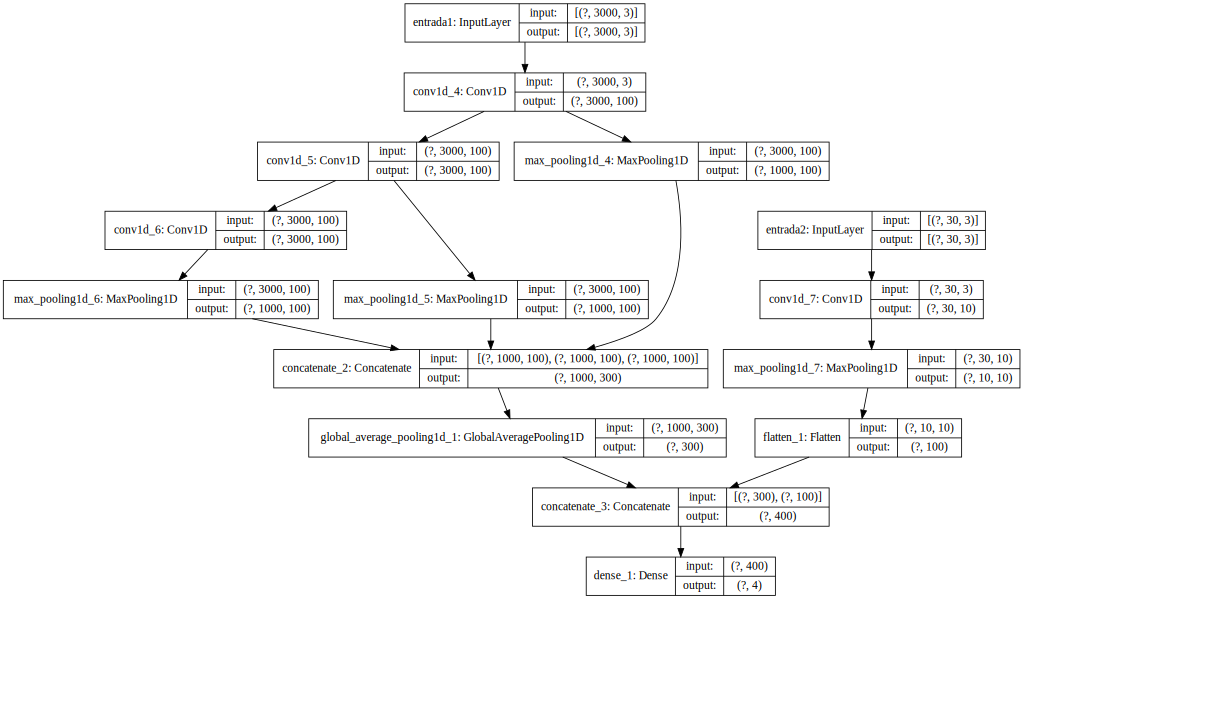

In [15]:
#Esta celda construye los modelos, a partir de los parametros especificados por cada una de las siguientes variables.

#Es el numero de filtros que cada capa convolucional utiliza.
numFiltros = np.array([100, 100, 100, 100, 100, 10])

#Es el tamaño de los filtros utilizados en cada capa convolucional.
tamFiltros = np.array([3, 5, 10, 8, 8, 5])

#Es el tamaño de cada capa de Pooling.
tamPooling = np.array([3, 3, 3, 3, 3, 3])

#Es el numero de neuronas en cada capa de la red neuronal que sigue despues de la parte convolucional.
numNeuronas = np.array([10, 20, 10])

#Es el tipo de optimizador a utilizar.
#Se pueden especificar: "sgd", "adam" o "rmsprop"
optimizer="adam"

#Es la tasa de aprendizaje del optimizador.
tasa = 0.001

#Es el parametro de regularizacion a utilizar.
alpha = 0.01

#En esta linea se crea el modelo con los parametros indicados.
#Al ejecutar esta linea tambien se muestra un resumen de la red, indicando el numero
#total de parametros y las capas incluidas.
modelo = crearModelo4(tasa, alpha, numFiltros, tamFiltros, tamPooling, numNeuronas, optimizer)

#Esta linea muestra un diagrama de la red neuronal.
SVG(model_to_dot(modelo, show_shapes = True, expand_nested = True, dpi = 60).create(prog='dot', format='svg'))

In [0]:
epocas = 4
batchSize = 512
# hist = modelo.fit(x_train, y_train, verbose = 1, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize)
# hist = modelo.fit(x_train, y_train, verbose = 1, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize, class_weight = pesosClases)

#Esta es para crearModelo3.

# hists = []
# hist = None

rutaModelo = "drive/My Drive/ModelosExamen2/Modelo4_3.json"
rutaPesos = "drive/My Drive/ModelosExamen2/PesosModelo4_3.h5"
rutaDiagrama = "drive/My Drive/ModelosExamen2/DiagramaModelo4_3.png"

for i in range(0,5):
  # hist = modelo.fit(x_train, y_train, verbose = 1, validation_data=(x_test, y_test), epochs = epocas, batch_size = batchSize)#, class_weight = pesosClases)
# # hist = modelo.fit([x_train1, x_train2], y_train, validation_data=([x_test1, x_test2], y_test), epochs = epocas, batch_size = batchSize)#, class_weight = pesosClases)
  hist = modelo.fit([x_train1, x_train2], y_train, verbose = 1, validation_data=([x_test1, x_test2], y_test), epochs = epocas, batch_size = batchSize)
  
  hists.append(hist)
  
  guardarModelo(modelo, rutaModelo, rutaPesos, rutaDiagrama)

  y_prob = modelo.predict([x_train1, x_train2])
  y_pred = y_prob.argmax(axis=-1)
                        
  resultadosEntrenamiento = Resultados(y_train, y_pred, hist)
  resultadosEntrenamiento.graficarHistoria()

  y_prob = modelo.predict([x_test1, x_test2])
  y_pred = y_prob.argmax(axis=-1)
                        
  resultadosValidacion = Resultados(y_test, y_pred, hist)

  resultadosEntrenamiento.darReporte()
  resultadosValidacion.darReporte()
  
  resultadosEntrenamiento.graficarMatrizConfusion()
  resultadosValidacion.graficarMatrizConfusion()

Train on 227240 samples, validate on 24929 samples
Epoch 1/4
 44544/227240 [====>.........................] - ETA: 2:12 - loss: 0.1751 - sparse_categorical_accuracy: 0.9388

In [0]:
numFiltros = np.array([100, 50, 20])
tamFiltros = np.array([6, 6, 6])
tamPooling = np.array([6, 6, 6])
optimizer="adam"
numNeuronas = np.array([10, 8, 6])

parametros = dict(batch_size = [30],
               epochs = [5],
               pOptimizer = ["adam", "sgd"],#,"rmsprop"],
               pTasa = [0.01],
               pAlphas = [0.001],
               pNumFiltros = [numFiltros],
              pTamFiltros = [tamFiltros],
              pTamPooling = [tamPooling],
              pNumNeuronas = [numNeuronas]
              )

In [0]:
def GridSearch(pXtrain, pYtrain, pXtest, pYtest, pParameters):
  i=0
  parameters = []
  bestScore = 0
  bestModel=None
  bestHist = None
  contador=0
  for k in parametros.keys():
    parameters.append(pParameters.get(k))
  with progressbar.ProgressBar(max_value=len(list(itertools.product(*parameters)))) as bar:
    for p in itertools.product(*parameters):
      contador=+1
      bar.update(contador)
      modelo=crearModelo(p[3],p[4],p[5],p[6],p[7],p[8], p[2])
      hist = modelo.fit(pXtrain, pYtrain, verbose = 1, validation_data=(pXtest, pYtest), epochs = p[1], batch_size = p[0])
      l, score =modelo.evaluate(pXtest,pYtest)
      if score>bestScore:
        bestScore = score
        bestModel = modelo
        bestHist = hist
  return bestScore, bestModel, bestHist

N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Train on 7977 samples, validate on 887 samples
Epoch 1/5
7977/7977 [==============================] - 3s 361us/sample - loss: 1.6520 - sparse_categorical_accuracy: 0.3236 - val_loss: 1.6377 - val_sparse_categorical_accuracy: 0.2954
Epoch 2/5
7977/7977 [==============================] - 2s 302us/sample - loss: 1.6042 - sparse_categorical_accuracy: 0.3412 - val_loss: 1.6478 - val_sparse_categorical_accuracy: 0.2954
Epoch 3/5
7977/7977 [==============================] - 2s 304us/sample - loss: 1.6057 - sparse_categorical_accuracy: 0.3421 - val_loss: 1.6405 - val_sparse_categorical_accuracy: 0.2954
Epoch 4/5
7977/7977 [==============================] - 2s 305us/sample - loss: 1.6134 - sparse_categorical_accuracy: 0.3273 - val_loss: 1.6373 - val_sparse_categorical_accuracy: 0.2954
Epoch 5/5
887/887 [==============================] - 0s 143us/sample - loss: 1.6402 - sparse_categorical_accuracy: 0.2954


 50% (1 of 2) |#############             | Elapsed Time: 0:00:13 ETA:   0:00:13

Train on 7977 samples, validate on 887 samples
Epoch 1/5
7977/7977 [==============================] - 3s 349us/sample - loss: 1.6346 - sparse_categorical_accuracy: 0.3383 - val_loss: 1.6308 - val_sparse_categorical_accuracy: 0.2965
Epoch 2/5
7977/7977 [==============================] - 2s 306us/sample - loss: 1.5496 - sparse_categorical_accuracy: 0.3894 - val_loss: 1.5556 - val_sparse_categorical_accuracy: 0.3901
Epoch 3/5
7977/7977 [==============================] - 2s 302us/sample - loss: 1.4849 - sparse_categorical_accuracy: 0.4159 - val_loss: 1.5129 - val_sparse_categorical_accuracy: 0.3890
Epoch 4/5
7977/7977 [==============================] - 2s 303us/sample - loss: 1.4540 - sparse_categorical_accuracy: 0.4355 - val_loss: 1.4913 - val_sparse_categorical_accuracy: 0.4002
Epoch 5/5
887/887 [==============================] - 0s 144us/sample - loss: 1.4619 - sparse_categorical_accuracy: 0.4036


100% (2 of 2) |##########################| Elapsed Time: 0:00:27 Time:  0:00:27


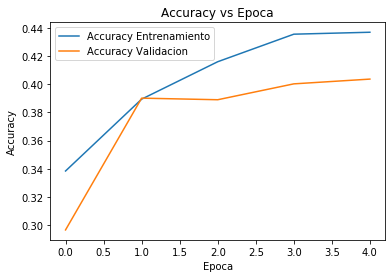

In [0]:
bestScore, bestModel, bestHist = GridSearch(x_train,y_train,x_test,y_test,parametros)
graficarHistoria(bestHist)

#Resultados